### Bayesian RNN
#### Copyright (C) 2020 Krzysztof Rusek AGH University of Science and Technology.

'''
 *
 * Copyright (C) 2020 AGH University of Science and Technology.
 *
 * Licensed under the Apache License, Version 2.0 (the "License");
 * you may not use this file except in compliance with the License.
 * You may obtain a copy of the License at:
 *
 *     http://www.apache.org/licenses/LICENSE-2.0
 *
 * Unless required by applicable law or agreed to in writing, software
 * distributed under the License is distributed on an "AS IS" BASIS,
 * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 * See the License for the specific language governing permissions and
 * limitations under the License.
 *
'''

In [1]:
import numpy as np
import seaborn as  sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras_svi import svi
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
sns.set()

# Dataset

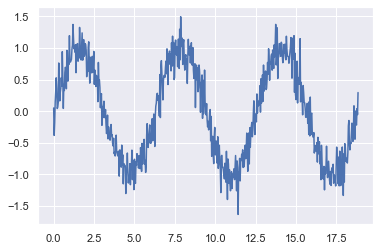

In [7]:
Nmax=6
tmax=Nmax*100
t=np.linspace(0, Nmax*np.pi, Nmax*100)

x= (np.sin(t) + np.random.normal(size=t.shape, scale=0.2)).astype(np.float32)

sns.lineplot(t,x)
plt.show()


In [8]:
split=int(tmax*0.7)
sequence_length=10
train_ds=tf.keras.preprocessing.timeseries_dataset_from_array(x[:split],targets=None, sequence_length=sequence_length)
test_ds=tf.keras.preprocessing.timeseries_dataset_from_array(x[split:],targets=None, sequence_length=sequence_length)

def fn(a):
    return (a[...,:-1,tf.newaxis], a[:,-1, tf.newaxis])

train_ds=train_ds.map(fn)
test_ds=test_ds.map(fn)

# MLE

In [9]:
mle_model = tf.keras.Sequential([
    tf.keras.layers.GRU(8),
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

In [10]:
mle_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y, rv_y: -rv_y.log_prob(y)
    #loss=tf.keras.losses.MeanSquaredError()
)


In [11]:
h = mle_model.fit(x=train_ds,
                  epochs=100,
                  validation_data=test_ds,
                  verbose=0)

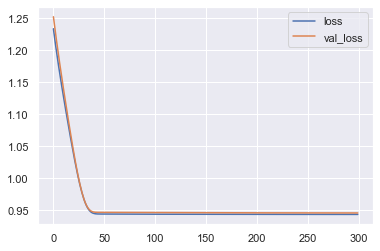

In [12]:
pd.DataFrame(h.history).plot()
plt.show()

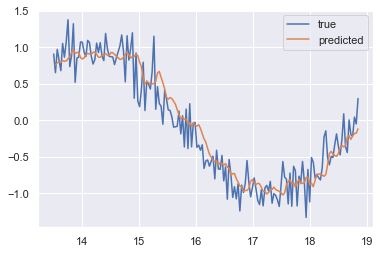

In [14]:
p=[]
begin=split+sequence_length-1
for i in range(begin,tmax-1):
    p.append(mle_model(x[i-9:i][np.newaxis,:,np.newaxis]).mean().numpy().flatten())

plt.plot(t[begin:],x[begin:], label="true")
plt.plot(t[begin+1:],p, label="predicted")
plt.legend()


plt.show()


# Bayes

In [62]:
_model = tf.keras.Sequential([
    tf.keras.layers.GRU(8),
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

def _make_posterior(v):
    n = len(v.shape)
    print(v.name)
    return tfd.Independent(tfd.Normal(loc=tf.Variable(tf.convert_to_tensor(v)),
                                      scale=tfp.util.TransformedVariable(0.2 + tf.zeros_like(v),
                                                                         #tfb.Softplus()(tfb.Scale(0.2)))),
                                                                         tfb.Softplus())),

                           reinterpreted_batch_ndims=n,
                           name="posterior/"+v.name)


def _make_prior(posterior):
    n = len(posterior.event_shape)
    name = posterior.name
    name = 'prior/'+name
    print(name)
    if name.find('bias')>0:
        return tfd.Independent(tfd.Normal(tf.zeros(posterior.event_shape), 5.),
                               reinterpreted_batch_ndims=n,
                               name = name)
    else:
        return tfd.Independent(tfd.Normal(tf.zeros(posterior.event_shape), 2.),
                               reinterpreted_batch_ndims=n,
                               name = name)

In [64]:
bayesian_model = svi.SVI(_model,
                         kl_scale=1./(0.7*len(t)),
                         prior_fn=_make_prior,
                         posterior_fn=_make_posterior
                         )

bayesian_model.compile(
    loss=lambda y, rv_y: -rv_y.log_prob(y),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001))

h=bayesian_model.fit(x=train_ds,
                     epochs=800,
                     validation_data=test_ds,
                     verbose=0)

gru_4/gru_cell_4/kernel:0
gru_4/gru_cell_4/recurrent_kernel:0
gru_4/gru_cell_4/bias:0
dense_4/kernel:0
dense_4/bias:0
prior/svi_3_posterior_gru_4_gru_cell_4_kernel_0
prior/svi_3_posterior_gru_4_gru_cell_4_recurrent_kernel_0
prior/svi_3_posterior_gru_4_gru_cell_4_bias_0
prior/svi_3_posterior_dense_4_kernel_0
prior/svi_3_posterior_dense_4_bias_0


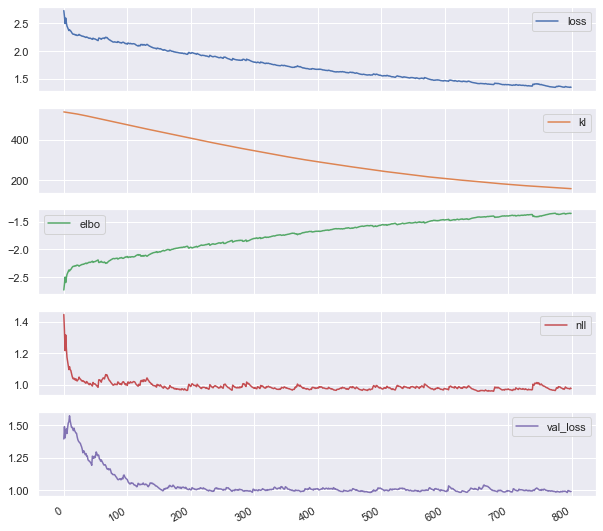

In [65]:
pd.DataFrame(h.history).ewm(alpha=0.1, adjust=True).mean().plot(subplots=True, figsize=(10,10))

plt.show()

In [66]:
p=[]
s=[]

for i in range(begin,tmax-1):
    preds = [bayesian_model(x[i-9:i][np.newaxis,:,np.newaxis]).mean().numpy().flatten() for _ in range(30)]
    p.append(np.mean(preds))
    s.append(np.std(preds))

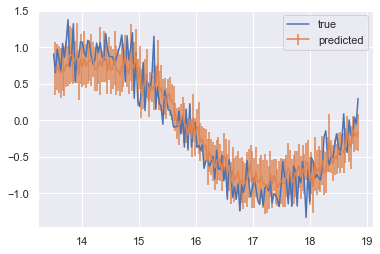

In [67]:
plt.plot(t[begin:],x[begin:], label="true")
plt.errorbar(t[begin+1:],p,yerr=s, label="predicted")
plt.legend()

plt.show()

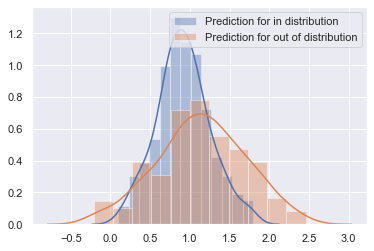

In [68]:
pred_true=[]
pred_oods=[]

true = x[begin:begin+9][np.newaxis,:,np.newaxis]
oods = true+4.0


for i in range(200):
    pred_true.append(bayesian_model(true).mean().numpy().flatten())
    pred_oods.append(bayesian_model(oods).mean().numpy().flatten())

sns.distplot(pred_true, label="Prediction for in distribution")
sns.distplot(pred_oods,label="Prediction for out of distribution")
plt.legend()
plt.show()

In [69]:
print(list(map(np.std,[pred_true, pred_oods])))

[0.3335728, 0.55274934]


Text(0.5, 1.0, 'SNR')

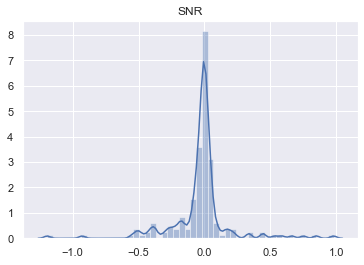

In [71]:
sns.distplot(bayesian_model.posterior.mean()[1]/bayesian_model.posterior.stddev()[1])
plt.title('SNR')